# Hand-Eye Calibration

This notebook provides hand-eye calibration for the AprilTag minimal working example. It is intended for development use only. The resulting hand-eye transformation matrix (`hand_eye_calibration.npy`) will be hard-coded into the main notebook   (src\ac_training_lab\apriltag_hardware_demo\apriltag_hardware_demo.ipynb) for system operation.

## Requirements

In [175]:
%pip install numpy scipy opencv-python pillow matplotlib gradio-client

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Helpers
`lock_cobot_position`
Lock cobot to the current position after adjust cobot position

In [176]:
import time
import json

def lock_cobot_position(client, user_id, speed=10):
    """
    Queries current cobot joint angles and sends them back to lock the position.

    Parameters:
    - client: your gradio client
    - user_id: ID for the prediction queue
    - speed: speed for send_angles (default: 10)
    """
    # Step 1: query current joint angles
    raw_result = client.predict(
        user_id=user_id,
        api_name="/query_angles"
    )

    print("Raw response:", raw_result)

    try:
        result = json.loads(raw_result[0])
    except Exception as e:
        print("Failed to parse JSON response:", e)
        return

    if "angles" not in result:
        print("Failed to get angles from cobot.")
        return

    angles = result["angles"]
    print("Queried current angles:", angles)

    # Step 2: convert to expected named params
    payload = {
        f"angle{i}": angle for i, angle in enumerate(angles)
    }
    payload["movement_speed"] = speed

    # Step 3: send angles to lock position
    try:
        response = client.predict(
            user_id=user_id,
            **payload,
            api_name="/control_angles"
        )
        print("Sent angles to lock position.")
        print("Server response:", response)
    except Exception as e:
        print("Failed to send angles:", e)



### `display_image` and `display_result`

- `display_image(image_path)`: Displays the image at the given path (used to check camera view or results).
- `display_result(result)`: Parses and prints server response, shows queue status and detection results, and displays image if available.

In [177]:
import matplotlib.pyplot as plt
from PIL import Image
import json

def display_image(image_path):
	try:
		img = Image.open(image_path).convert("RGB")
		plt.imshow(img)
		plt.title("Cobot view")
		plt.show()
	except Exception as e:
		print(f"An error occurred: {e}")

def display_result(result):
	queue_status_str = result[-1].replace('\n', ' ')
	print(f"queue status: {queue_status_str}")
	print(f"response json: {None if result[0] is None else json.loads(result[0])}")
	if len(result) == 3:
		if result[1] is None:
			return
		display_image(result[1]['value'])

## Connecting to the Cobot

Connect to the cobot to begin data collection and calibration.

In [178]:
from gradio_client import Client
import uuid
import getpass  

USER_ID = str(uuid.uuid4())
print(f"Your user id: {USER_ID}")

hf_token = getpass.getpass("Enter your Hugging Face Token:")

client = Client(
    "AccelerationConsortium/cobot280pi-gradio-g9sv",
    hf_token=hf_token
)

client.view_api()

result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)

Your user id: a2e4d0f6-423e-4299-9d13-58c1ce340314
Loaded as API: https://accelerationconsortium-cobot280pi-gradio-g9sv.hf.space ✔
Client.predict() Usage Info
---------------------------
Named API endpoints: 15

 - predict(user_id, api_name="/query_angles") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_coords") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_gripper") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_camera") -> (response, value_72, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  

Moves the cobot to the predefined home position.

In [179]:
INITIAL_HOME_POSE = {
    "angle0": 0,
    "angle1": 0,
    "angle2": 0,
    "angle3": 0,
    "angle4": 0,
    "angle5": 0,
    "movement_speed": 50
}

result = client.predict(
    user_id=USER_ID,
    **INITIAL_HOME_POSE, 
    api_name="/control_angles"
)
display_result(result)

queue status: Your turn! Time remaining: 119.19 seconds.
response json: {'success': True, 'command': 'control/angles'}


## Data Collection Instructions

1. Print a checkerboard and stick it to a wall or stable surface.

2. Run the code cells about **15 to 20 times**. Each time:

- Run the **first cell** to release all servos, allowing you to move the cobot by hand.  
- Adjust the cobot so that the checkerboard is clearly visible. Use the **second cell** to check the camera view.  
- Use the **third cell** to lock the cobot in place at the current position.  
- Run the **fourth cell** to save the image and pose to a JSON file.

3. Try different angles and positions to improve calibration accuracy.




### 1. Release All Servos

In [ ]:
result = client.predict(
    user_id=USER_ID,
    api_name="/release_servos"
)
display_result(result)


Use this cell to check whether the coordinates are correct. Sometimes, due to movement latency or temporary failure, the reported coordinates may be inaccurate. In such cases, manually verify the cobot's position using the axis labels printed on the cobot.

In [432]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_coords"
)
print(result)
display_result(result)


('{\n    "success": true,\n    "coords": [\n        113.8,\n        -84.2,\n        299.5,\n        -89.77,\n        -39.46,\n        -86.98\n    ],\n    "command": "query/coords"\n}', 'Your turn!\nTime remaining: 27.87 seconds.')
queue status: Your turn! Time remaining: 27.87 seconds.
response json: {'success': True, 'coords': [113.8, -84.2, 299.5, -89.77, -39.46, -86.98], 'command': 'query/coords'}


In [421]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_angles"
)
print(result)
display_result(result)


('{\n    "success": true,\n    "angles": [\n        93.16,\n        39.02,\n        -76.81,\n        128.49,\n        -90.0,\n        -131.13\n    ],\n    "command": "query/angles"\n}', 'Your turn!\nTime remaining: 69.67 seconds.')
queue status: Your turn! Time remaining: 69.67 seconds.
response json: {'success': True, 'angles': [93.16, 39.02, -76.81, 128.49, -90.0, -131.13], 'command': 'query/angles'}


#### 2. Check Camera View

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\b6d4f4d39056ad43a6a0ed837292aec6eb6f86f812d09632cd039c2a88bac56d\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 77.88 seconds.')
queue status: Your turn! Time remaining: 77.88 seconds.
response json: {'success': True, 'command': 'query/camera'}


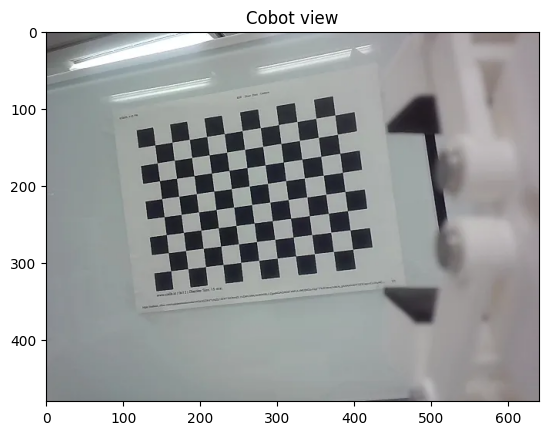

In [420]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)

### 3. Lock Cobot to the Current Position

In [419]:
lock_cobot_position(client, USER_ID)

Raw response: ('{\n    "success": true,\n    "angles": [\n        92.63,\n        39.72,\n        -76.72,\n        126.73,\n        -89.64,\n        -130.51\n    ],\n    "command": "query/angles"\n}', 'Your turn!\nTime remaining: 101.26 seconds.')
Queried current angles: [92.63, 39.72, -76.72, 126.73, -89.64, -130.51]
Sent angles to lock position.
Server response: ('{\n    "success": true,\n    "command": "control/angles"\n}', 'Your turn!\nTime remaining: 99.09 seconds.')


### 4. Save Data into JSON

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\9d8732533b67020ce98f8c080fc25e985c675c3013866a38cfd0ccb9277a5932\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 8.78 seconds.')
queue status: Your turn! Time remaining: 8.78 seconds.
response json: {'success': True, 'command': 'query/camera'}


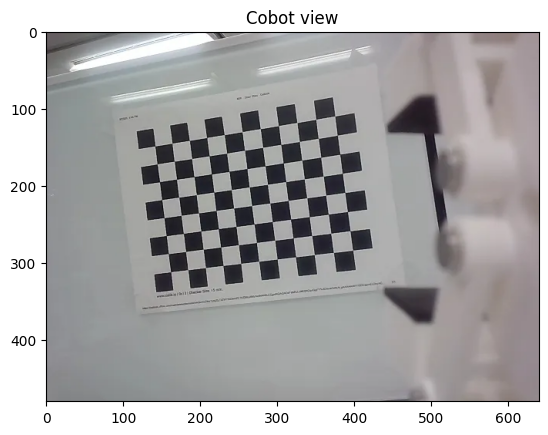

('{\n    "success": true,\n    "coords": [\n        113.8,\n        -84.2,\n        299.5,\n        -89.77,\n        -39.46,\n        -86.98\n    ],\n    "command": "query/coords"\n}', 'Your turn!\nTime remaining: 6.10 seconds.')
queue status: Your turn! Time remaining: 6.10 seconds.
response json: {'success': True, 'coords': [113.8, -84.2, 299.5, -89.77, -39.46, -86.98], 'command': 'query/coords'}
Record added to f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration_data.json


In [435]:
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import cv2

# Get current working directory
current_dir = os.getcwd()
json_path = os.path.join(current_dir, "hand_eye_calibration_data.json")

# Create directory to save calibration images
image_dir = os.path.join(current_dir, "hand_eye_calibration_images")
os.makedirs(image_dir, exist_ok=True)

if not os.path.exists(json_path) or os.path.getsize(json_path) == 0:
    data_json = {"records": []}
else:
    with open(json_path, 'r') as f:
        data_json = json.load(f)

result_img = client.predict(
    user_id=USER_ID,
    api_name="/query_camera"
)
print(result_img)
display_result(result_img)

image_path = result_img[1]["value"]
image_array = cv2.imread(image_path)

# Generate a new file name for the saved image
image_id = len(data_json["records"]) + 1
save_name = f"{image_id}.jpg"
save_path = os.path.join(image_dir, save_name)
cv2.imwrite(save_path, image_array)

# Call the /query_coords API to get the cobot's pose
result_pose = client.predict(
    user_id=USER_ID,
    api_name="/query_coords"
)
print(result_pose)
display_result(result_pose)

# Parse the returned pose data (JSON string inside a tuple)
pose_dict = json.loads(result_pose[0])
query_coords = [float(coord) for coord in pose_dict["coords"]]

# Convert position to meters and angles to radians
x, y, z = [coord / 1000 for coord in query_coords[:3]]  # from mm to meters
rx_deg, ry_deg, rz_deg = query_coords[3:]
rx, ry, rz = np.radians([rx_deg, ry_deg, rz_deg])       # degrees to radians

# Convert rotation from Euler angles to a 3x3 rotation matrix
rotation = R.from_euler('xyz', [rx, ry, rz]).as_matrix()

# Build the 4x4 pose matrix
pose_matrix = np.eye(4)
pose_matrix[:3, :3] = rotation
pose_matrix[:3, 3] = [x, y, z]

# Create and append a new calibration record
record = {
    "image_path": os.path.join("hand_eye_calibration_images", save_name),  # relative path
    "pose_matrix": pose_matrix.tolist()
}
data_json["records"].append(record)

# Save updated records back to the JSON file
with open(json_path, 'w') as f:
    json.dump(data_json, f, indent=2)

print(f"Record added to {json_path}")



The following code deletes the most recent data if you choose to discard it.

In [434]:
import os
import json

current_dir = os.getcwd()
json_path = os.path.join(current_dir, "hand_eye_calibration_data.json")
image_dir = os.path.join(current_dir, "hand_eye_calibration_images")

with open(json_path, 'r') as f:
    data_json = json.load(f)

if len(data_json["records"]) > 0:
    last_record = data_json["records"].pop()
    image_path = os.path.join(current_dir, last_record["image_path"])
    if os.path.exists(image_path):
        os.remove(image_path)
    with open(json_path, 'w') as f:
        json.dump(data_json, f, indent=2)
    print("Last record has been removed.")
else:
    print("No records to remove.")

Last record has been removed.


## Main function for hand-eye calibration
Next, we define helper functions for calibration, and specify the checkerboard parameters:  
- `XX`: number of inner corners along the width  
- `YY`: number of inner corners along the height  
- `L`: size of each square (in meters)

The function will perform both camera calibration and hand-eye calibration, and save the camera intrinsics into `camera_params.npy` for later use.

In [436]:
XX = 8
YY = 11
L = 0.01905  # need to check this !!!

In [437]:
def func(json_path, camera_params_path):
    with open(json_path, 'r') as f:
        data_json = json.load(f)

    if len(data_json["records"]) == 0:
        print("No records found in JSON.")
        return

    objp = np.zeros((XX * YY, 3), np.float32)
    objp[:, :2] = np.mgrid[0:XX, 0:YY].T.reshape(-1, 2)
    objp *= L

    obj_points = []
    img_points = []

    R_tool = []
    t_tool = []

    criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 30, 0.001)

    for record in data_json["records"]:
        image_path = os.path.join(os.path.dirname(json_path), record["image_path"])

        if not os.path.exists(image_path):
            print(f"Image {image_path} not found. Skipping.")
            continue

        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        size = gray.shape[::-1]

        ret, corners = cv2.findChessboardCorners(gray, (XX, YY), None)

        if ret:
            obj_points.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
            img_points.append(corners2)

            pose_matrix = np.array(record["pose_matrix"])
            R_tool.append(pose_matrix[:3, :3])
            t_tool.append(pose_matrix[:3, 3])
        else:
            print(f"Chessboard not detected in {image_path}")

    if len(obj_points) == 0:
        print("No valid images for calibration.")
        return

    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points,
        img_points,
        size,
        cameraMatrix=None,
        distCoeffs=None
    )

    np.save(camera_params_path, {
        "camera_matrix": K,
        "dist_coeff": dist
    })
    print(f"Saved camera parameters to {camera_params_path}")

    R_ce, t_ce = cv2.calibrateHandEye(R_tool, t_tool, rvecs, tvecs, cv2.CALIB_HAND_EYE_TSAI)
    print(f"{len(obj_points)} valid checkerboard images were used for calibration.")

    return R_ce, t_ce


Finally, run `func()` to compute the hand-eye calibration and save the resulting matrices.

In [438]:
data_dir = os.getcwd()
json_path = os.path.join(data_dir, "hand_eye_calibration_data.json")
camera_params_path = os.path.join(data_dir, "camera_params.npy")
hand_eye_path = os.path.join(data_dir, "hand_eye_calibration.npy")

R_ce, t_ce = func(json_path, camera_params_path)

if R_ce is not None and t_ce is not None:
    hand_eye_params = {
        "rotation_matrix": R_ce,
        "translation_vector": t_ce
    }
    np.save(hand_eye_path, hand_eye_params)
    print(f"Saved hand-eye calibration to {hand_eye_path}")

Saved camera parameters to f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\camera_params.npy
16 valid checkerboard images were used for calibration.
Saved hand-eye calibration to f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration.npy


## JSON Data Management

### Clear JSON File and Image Folder

In [1]:
import os
import json

current_dir = os.getcwd()
json_path = os.path.join(current_dir, "hand_eye_calibration_data.json")
image_dir = os.path.join(current_dir, "hand_eye_calibration_images")

data_json = {"records": []}
with open(json_path, 'w') as f:
    json.dump(data_json, f, indent=2)
print(f"JSON file at {json_path} has been cleared and reset.")

if os.path.exists(image_dir):
    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print(f"All files in {image_dir} have been deleted.")
else:
    print(f"Image folder does not exist: {image_dir}")



JSON file at f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration_data.json has been cleared and reset.
All files in f:\AC\ac-training-lab\src\ac_training_lab\apriltag_hardware_demo\hand_eye_calibration_images have been deleted.
